In [3]:
import yaml
import networkx as nx
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass
from collections import defaultdict
from datetime import datetime, timedelta
from functools import partial
from itertools import tee

def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [4]:
def get_time(text: str):
    try:
        return datetime.strptime(text.removesuffix(".0"), "%Y-%m-%d %H:%M:%S")
    except ValueError:
        return datetime.strptime(text, "%d/%m/%Y %H:%M:%S")

maestro_data = pd.read_csv("../data/maestro-calculated.csv", low_memory=False)
maestro_data[maestro_data["workflow_name"] == "securitization-flow"]
maestro_data["cmd_time"] = maestro_data["cmd_time"].apply(get_time)

In [5]:
# why colon is not in quote in yaml wtf
pattern = re.compile(r"^(\s+[\w-]+: )(.*:.*)$", re.MULTILINE)

with open("../data/securitization-flow.yml") as file:
    content = ""
    for line in file:
        if(match := pattern.match(line)):
            pre, missing_quote = match.groups()
            content += f'{pre}"{missing_quote}"\n'
        else:
            content += line

    securization_flow_yaml = yaml.load(content, yaml.Loader)

In [6]:
securization_flow = nx.DiGraph()
for job_pre in securization_flow_yaml["workflows"][0]["jobs"]:
    if (job := job_pre.get("job", None)) or (job := job_pre.get("nop", None)) or (job := job_pre.get("jobReference", None)):
        name = job.get("name")
        securization_flow.add_node(name, name=name.replace("-", "\n"))
        for precondition in job.get("precondition", []):
            securization_flow.add_node(precondition, name=precondition.replace("-", "\n"))
            securization_flow.add_edge(precondition, job.get("name"))

In [7]:
# for node in securization_flow:
#     for predecessor in list(securization_flow.predecessors(node)):
#         subset = maestro_data[maestro_data["job_name"] == predecessor].copy()
#         for index, node_row in maestro_data[maestro_data["job_name"] == node].iterrows():
#             subset["delta"] = subset["cmd_time"] - node_row["cmd_time"]
#             new_column = subset[subset["delta"] >= timedelta()].sort_values("delta")
#             try:
#                 print(new_column.iloc[0].delta)
#             except IndexError:
#                 pass

In [17]:
times = defaultdict(partial(defaultdict, list))
business = {f"BD{i}": times.copy() for i in range(0, 10)}

for business_key in business.keys():
    maestro_copy = maestro_data[maestro_data["business-day"] == business_key]

    indexes = [0] + list(maestro_data[maestro_data["job_name"] == "reload-tactical-tables-post-securitization"].index)
    for index_start, index_end in pairwise(indexes):
        for node in securization_flow:
            for predecessor in list(securization_flow.predecessors(node)):
                subset = maestro_copy.iloc[index_start:index_end]

                end_node = subset[subset["job_name"] == node]
                start_node = subset[subset["job_name"] == predecessor]
                start = start_node["cmd_time"]
                end = end_node["cmd_time"]
                duration = start_node["processing-time"]
                if not start.empty and not end.empty:
                    # TODO: try to make multiple starts or multiple ends work
                    if len(start) == 1 and len(end) == 1:
                        time = (end.iloc[0] - start.iloc[0]).total_seconds() - duration.iloc[0]
                        if time >= 0:
                            business[business_key][node][predecessor].append(time)
                            times[node][predecessor].append(time)

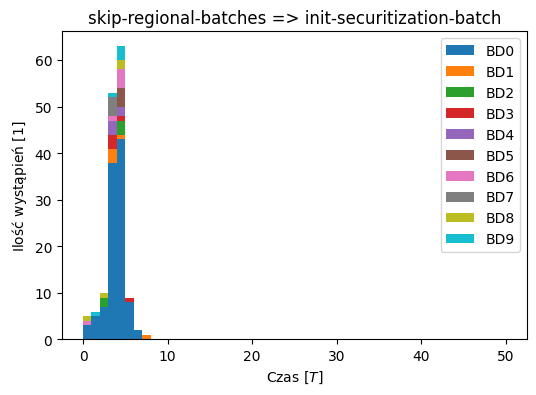

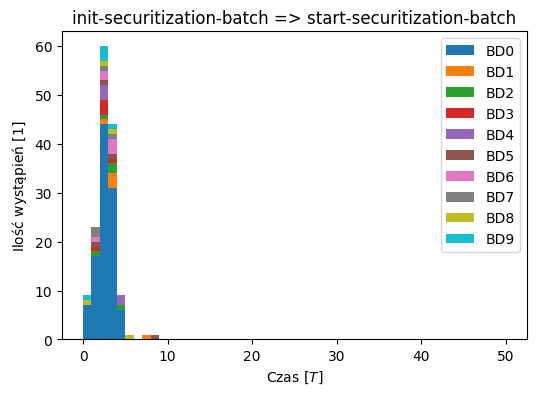

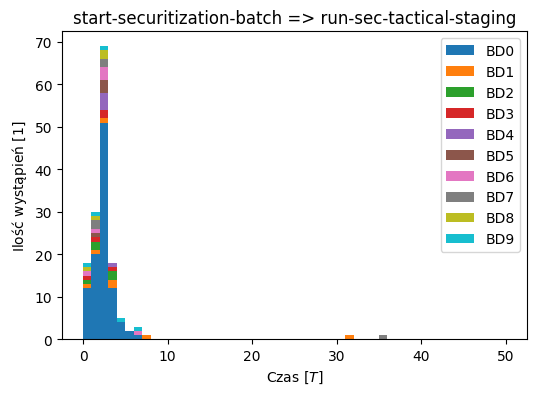

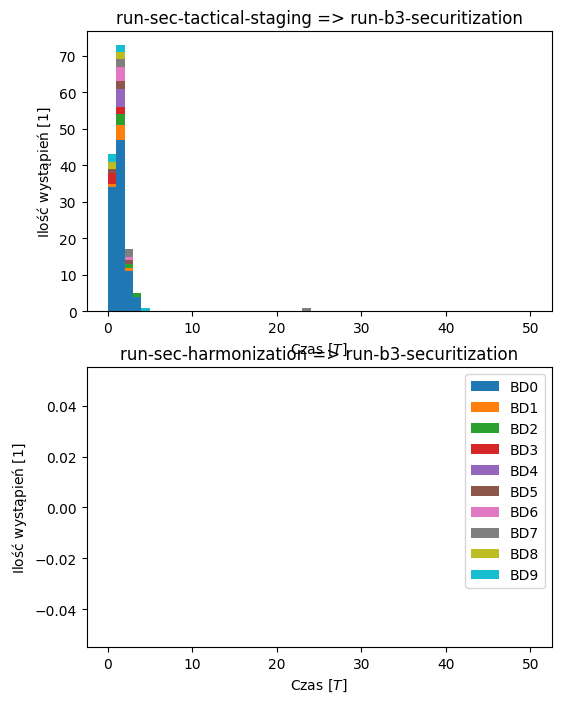

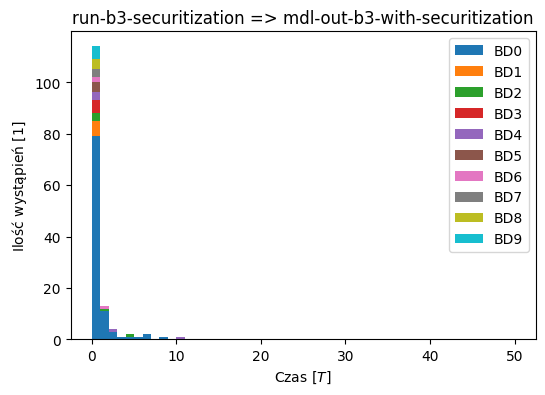

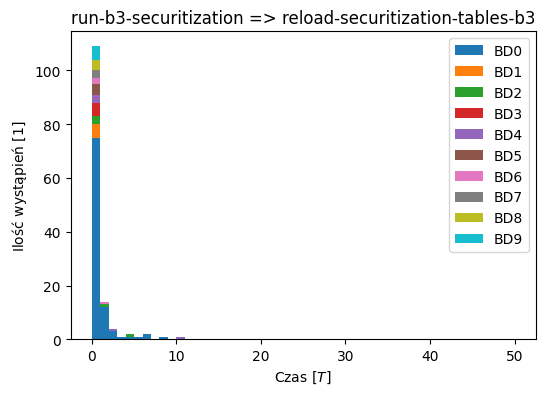

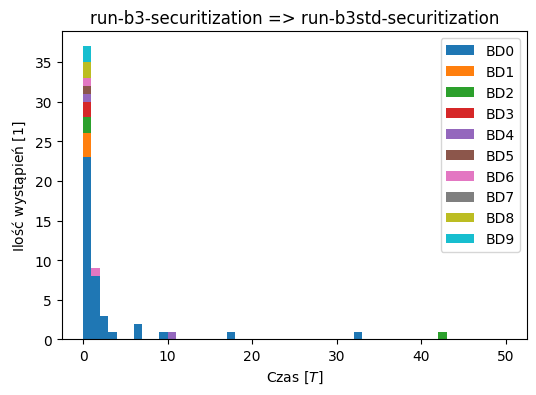

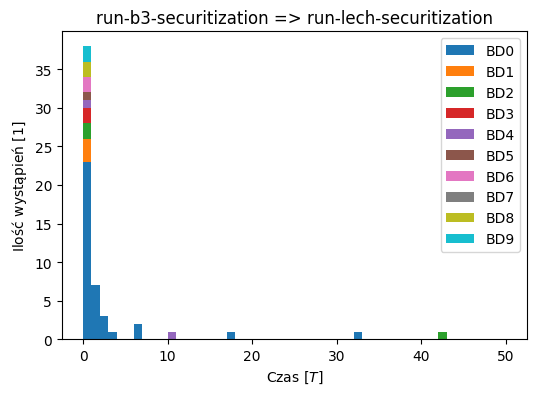

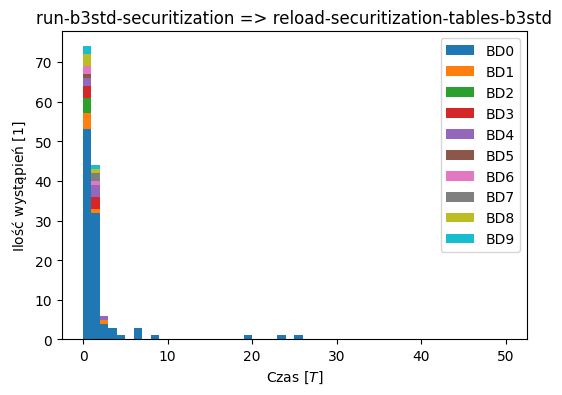

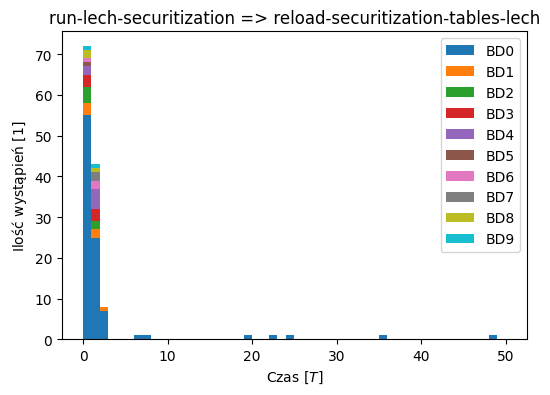

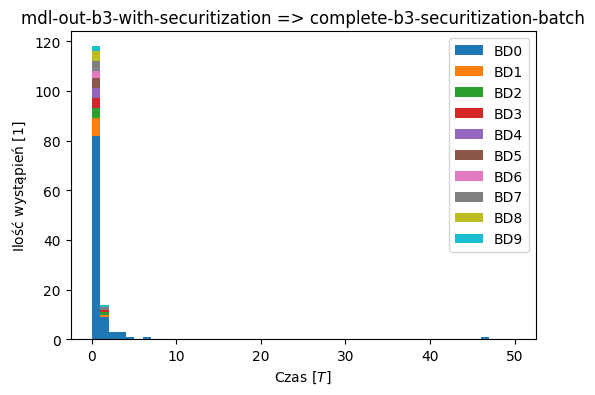

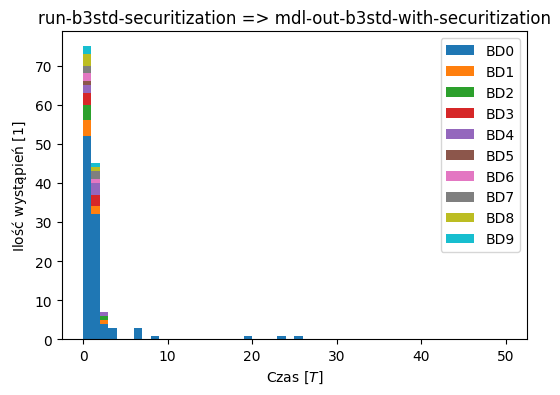

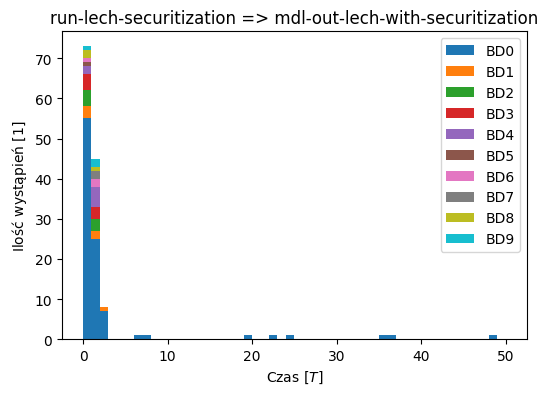

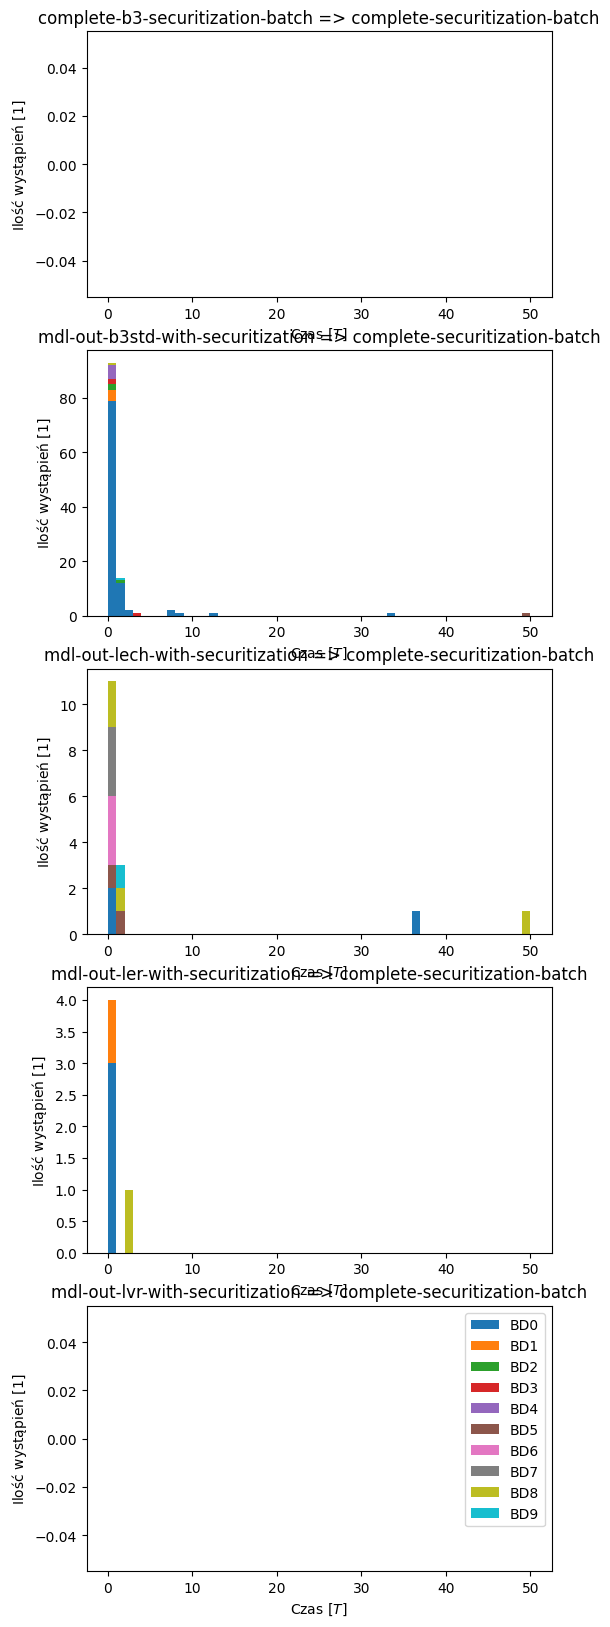

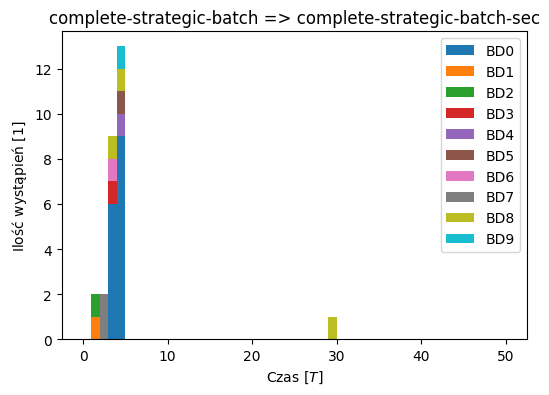

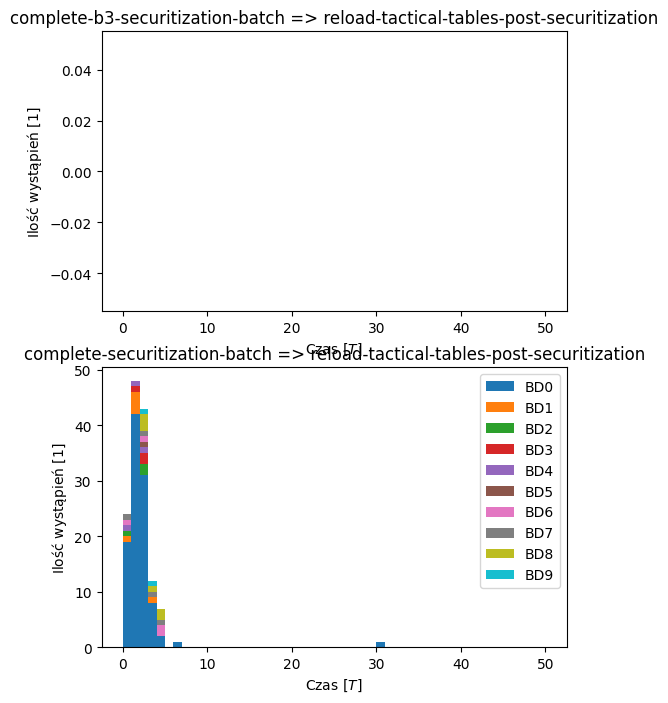

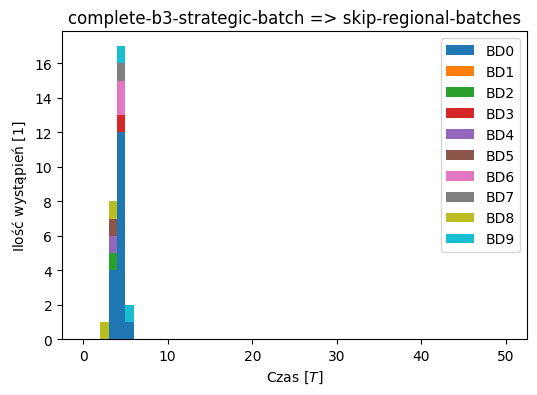

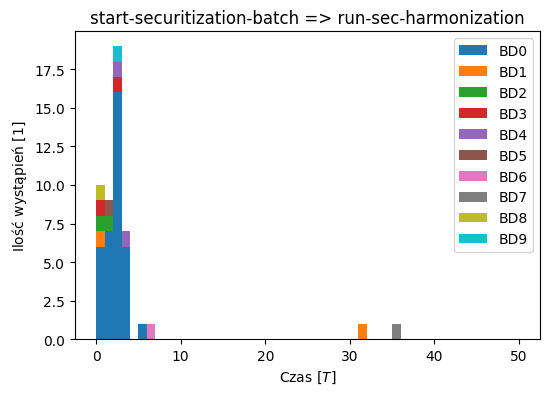

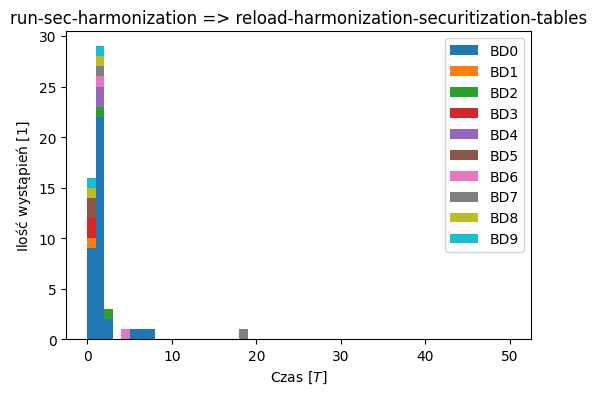

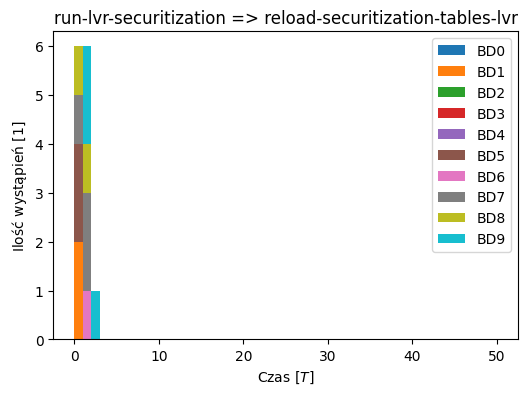

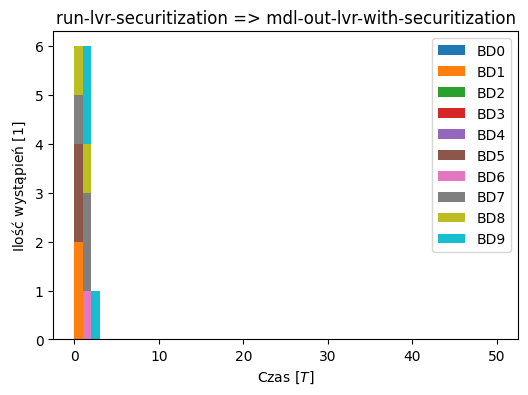

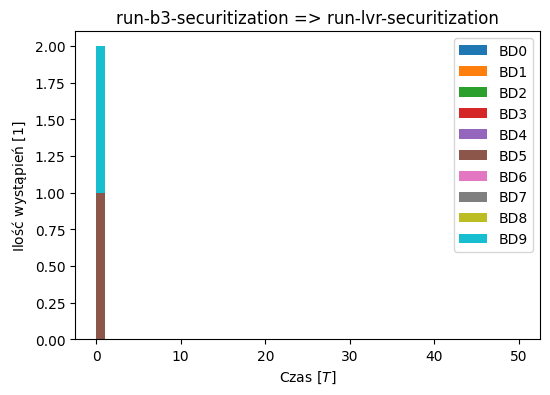

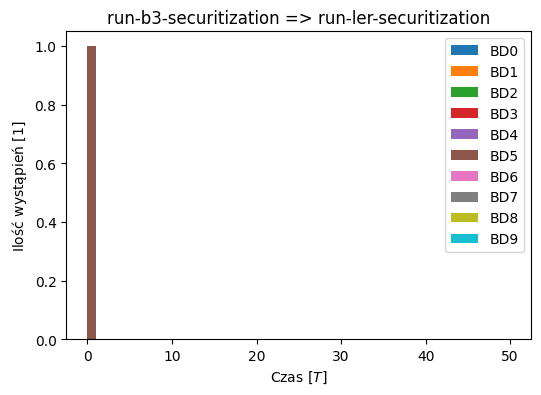

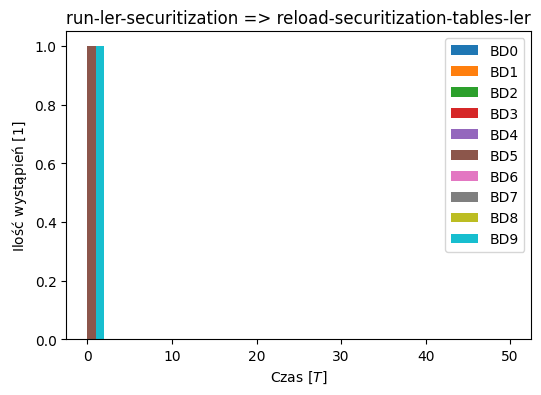

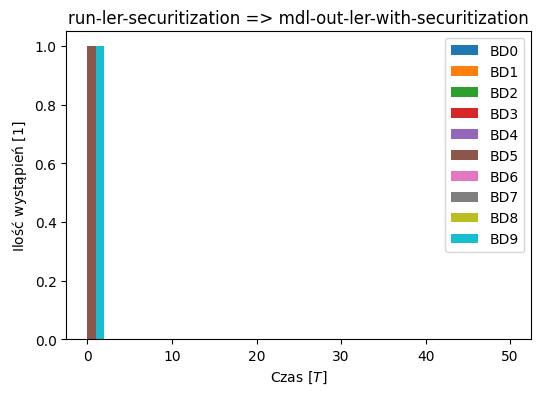

In [27]:
# for 
for node in times.keys():
    keys = list(times[node].keys())
    fig, ax = plt.subplots(len(keys), 1, figsize=(6, len(keys) *  4))
    
    for i, predecessor in enumerate(keys):
        if len(keys) > 1:
            axis = ax[i]
        else:
            axis = ax
        axis.set_xlabel("Czas [$T$]")
        axis.set_ylabel("Ilość wystąpień [$1$]")
        bds = list(business.keys())
        axis.hist([business[single_time][node][predecessor] for single_time in bds], label=bds, range=(0, 50), stacked=True, bins=50)
        axis.set_title(f"{predecessor} => {node}")
    axis.legend()
    # print()
    plt.show()